# EEGEmbedder - Convolutional based model

Notebook porównuje dzialanie jednego modelu typu konwolucyjnego w oparciu o parametry takie jak:

- ilosc wymiarow embeddingu
- zastosowanie rejecta w preprocessingu EEG (EEGDataExtractorV2)
- parametryzacja w t-SNE dla lepszej wizaulizacji

Ważnym elementem pracy jest kryterium uczenia modelu -> TripletLossWithMargin, lecz w wersji online mining
tj. trójki (anchor, positive, negative) wyznaczane są podczas treningu i w tej wersji brane są skrajne (najgorzej położone) tzw. hard_positive, hard_negative.

Zauwazylem lekką różnice na korzyść online TripletLoss w porównaniu do offline, gdzie trójki wybierane są przed treningiem


In [ ]:
from neuroguard.utils.random_seed import set_seed
from neuroguard.data.data_loader.eeg_data_extractor import EEGDataExtractor
from neuroguard.data.data_loader.eeg_data_extractor_v2 import EEGDataExtractorV2
from neuroguard.data.encode_features_labels import encode_features_and_labels
from neuroguard.models.similarity.conv import EEGEmbedder
from neuroguard.data.subject_based_split import split_by_user, create_dataloaders, create_online_dataloaders
from neuroguard.pipelines.conv_training import train_triplet, train_triplet_online
from neuroguard.pipelines.embedding_generation import extract_embeddings, extract_embeddings_online
import torch
from torch import nn
import torch.optim as optim
from neuroguard.utils.visualisations import plot_tsne
from neuroguard.commons.constant import DATASETS_FOLDER

# Dane z oryginalnego extractora


In [ ]:
DATA_DIR = f"{DATASETS_FOLDER}/Kolory/"

data_loader = EEGDataExtractor(data_dir=DATA_DIR)
eeg_df, participants_info = data_loader.extract_dataframe()
df, participants = data_loader.extract_dataframe()
labels = df['participant_id']
X, y, le = encode_features_and_labels(df)
set_seed(42)

# Dane z extractora z rejectem


In [ ]:
data_loader2 = EEGDataExtractorV2('data/Kolory')
df2, participants2 = data_loader2.extract_dataframe()
labels2 = df2['participant_id']
X2, y2, le2 = encode_features_and_labels(df2)
set_seed(42)

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.TripletMarginWithDistanceLoss(margin=0.5)

# Offline Triplet Loss - przyklad dla embeddingu 32 dim


In [18]:
model_32 = EEGEmbedder(embedding_dim=32).to(device)
optimizer = optim.Adam(model_32.parameters(), lr=0.001)

In [19]:
model_32

EEGEmbedder(
  (cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 25), stride=(1, 1), padding=(0, 12), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(4, 1), stride=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Dropout(p=0.25, inplace=False)
    (7): Conv2d(32, 64, kernel_size=(1, 15), stride=(1, 2), padding=(0, 7), bias=False)
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Dropout(p=0.25, inplace=False)
  )
  (global_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): Tanh()
  )
)

In [20]:
X_train, y_train, X_test, y_test, train_labels, test_labels = split_by_user(X,y, labels)
train_loader, test_loader = create_dataloaders(X_train, y_train, X_test, y_test)

In [24]:
X_train2, y_train2, X_test2, y_test2, train_labels2, test_labels2 = split_by_user(X2,y2, labels2)
train_loader2, test_loader2 = create_dataloaders(X_train2, y_train2, X_test2, y_test2)

In [ ]:
train_triplet(model_32, train_loader, criterion, optimizer, device, n_epochs = 20)

In [ ]:
all_embeddings_32, all_labels = extract_embeddings(model_32, test_loader, device)

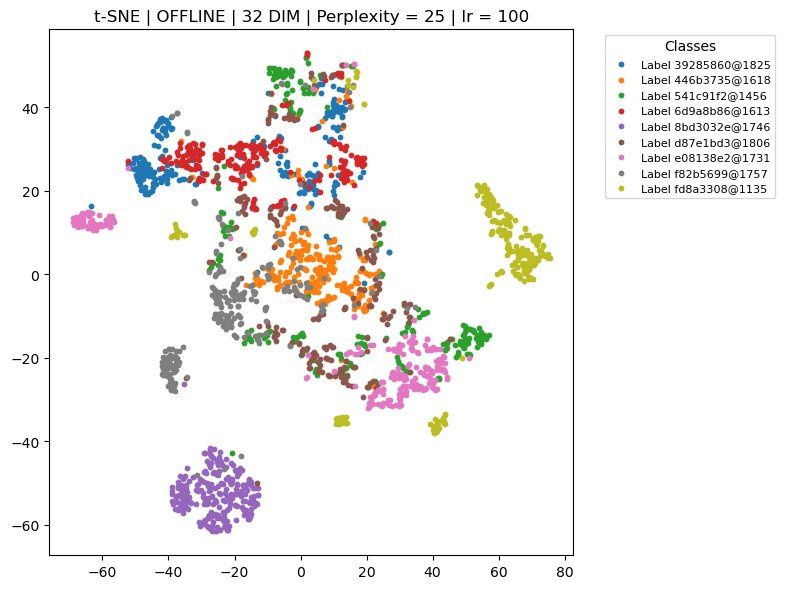

In [25]:
plot_tsne(all_embeddings_32, test_labels, perplexity = 25, learning_rate = 100, title = "t-SNE | OFFLINE | 32 DIM | Perplexity = 25 | lr = 100")

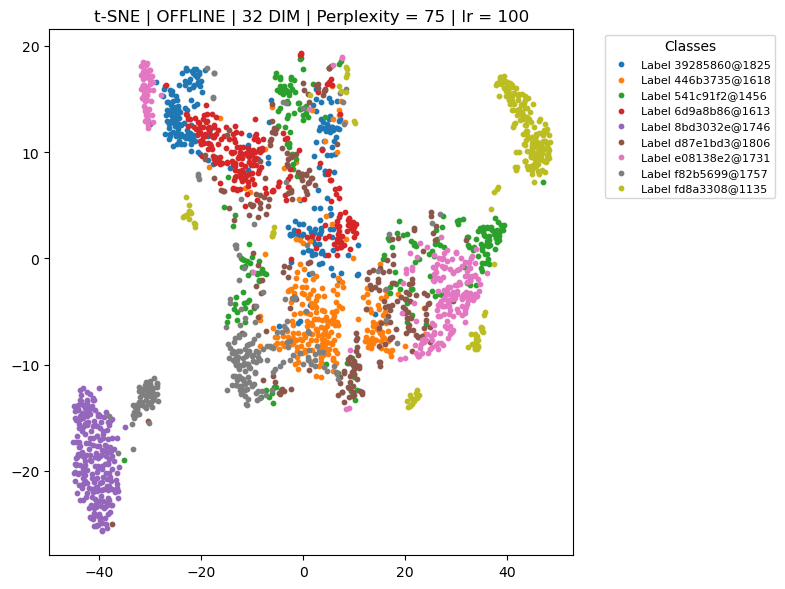

In [27]:
plot_tsne(all_embeddings_32, test_labels, perplexity = 75, learning_rate = 100, title = "t-SNE | OFFLINE | 32 DIM | Perplexity = 75 | lr = 100")

# Online 32 dim Embeddings


In [29]:
train_loader, test_loader = create_online_dataloaders(X_train, y_train, X_test, y_test)

In [31]:
model_online_32  = EEGEmbedder(embedding_dim=32).to(device)
optimizer = optim.Adam(model_online_32.parameters(), lr=0.001)

In [ ]:
train_triplet_online(model_online_32, train_loader, criterion, optimizer, device, n_epochs = 50)

In [33]:
all_embeddings_online, all_labels = extract_embeddings_online(model_online_32, test_loader, device)

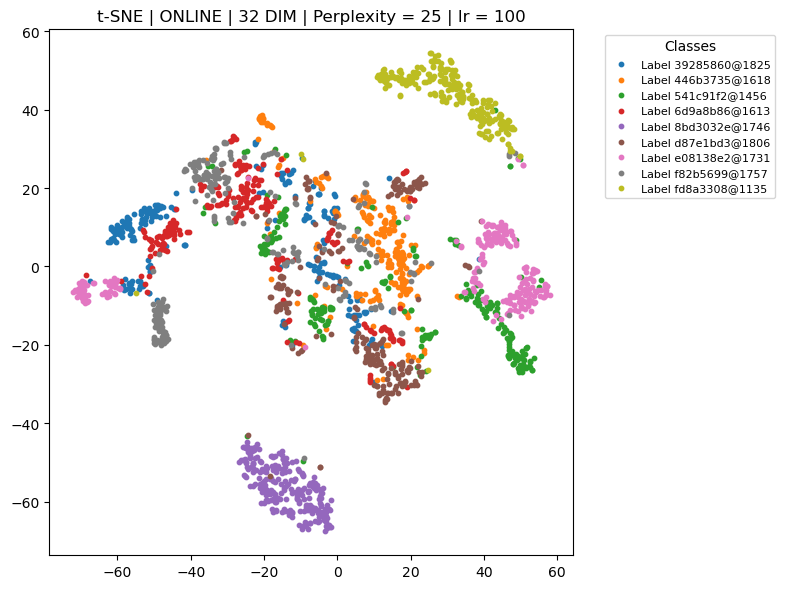

In [36]:
plot_tsne(all_embeddings_online, test_labels, perplexity = 25, learning_rate = 100, title = "t-SNE | ONLINE | 32 DIM | Perplexity = 25 | lr = 100")

# Online 64 embeddings


In [38]:
model_online_64  = EEGEmbedder(embedding_dim=64).to(device)
optimizer = optim.Adam(model_online_64.parameters(), lr=0.001)
train_triplet_online(model_online_64, train_loader, criterion, optimizer, device, n_epochs = 60)
all_embeddings_online_64, all_labels = extract_embeddings_online(model_online_64, test_loader, device)

Epoch 1/60 | Triplet Loss: 0.5538
Epoch 2/60 | Triplet Loss: 0.5020
Epoch 3/60 | Triplet Loss: 0.4759
Epoch 4/60 | Triplet Loss: 0.4162
Epoch 5/60 | Triplet Loss: 0.3320
Epoch 6/60 | Triplet Loss: 0.3062
Epoch 7/60 | Triplet Loss: 0.2799
Epoch 8/60 | Triplet Loss: 0.2522
Epoch 9/60 | Triplet Loss: 0.2569
Epoch 10/60 | Triplet Loss: 0.2329
Epoch 11/60 | Triplet Loss: 0.2102
Epoch 12/60 | Triplet Loss: 0.2050
Epoch 13/60 | Triplet Loss: 0.1913
Epoch 14/60 | Triplet Loss: 0.1832
Epoch 15/60 | Triplet Loss: 0.1730
Epoch 16/60 | Triplet Loss: 0.1566
Epoch 17/60 | Triplet Loss: 0.1609
Epoch 18/60 | Triplet Loss: 0.1406
Epoch 19/60 | Triplet Loss: 0.1499
Epoch 20/60 | Triplet Loss: 0.1395
Epoch 21/60 | Triplet Loss: 0.1448
Epoch 22/60 | Triplet Loss: 0.1284
Epoch 23/60 | Triplet Loss: 0.1384
Epoch 24/60 | Triplet Loss: 0.1229
Epoch 25/60 | Triplet Loss: 0.1262
Epoch 26/60 | Triplet Loss: 0.1344
Epoch 27/60 | Triplet Loss: 0.1188
Epoch 28/60 | Triplet Loss: 0.1000
Epoch 29/60 | Triplet Loss: 0

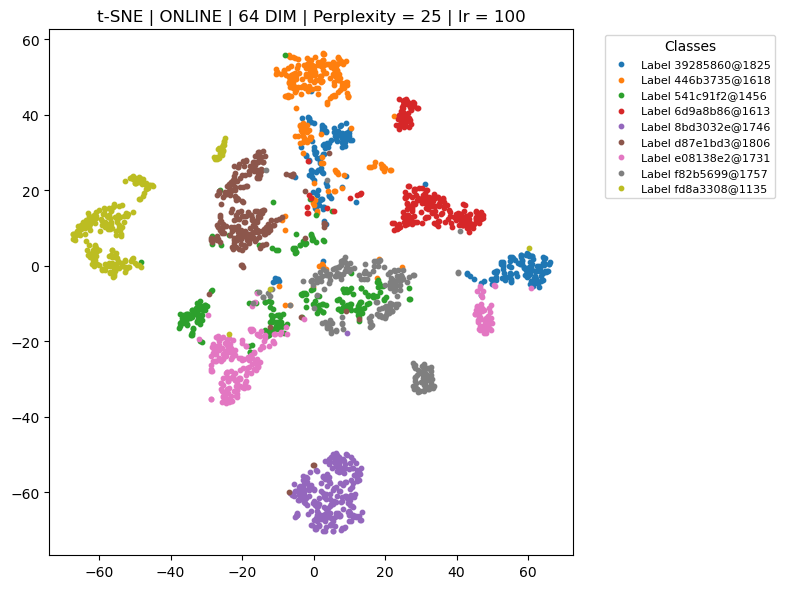

In [39]:
plot_tsne(all_embeddings_online_64, test_labels, perplexity = 25, learning_rate = 100, title = "t-SNE | ONLINE | 64 DIM | Perplexity = 25 | lr = 100")

# Online 128 Embeddings


In [ ]:
model_online_128  = EEGEmbedder(embedding_dim=128).to(device)
optimizer = optim.Adam(model_online_128.parameters(), lr=0.001)
train_triplet_online(model_online_128, train_loader, criterion, optimizer, device, n_epochs = 60)
all_embeddings_online_128, all_labels = extract_embeddings_online(model_online_128, test_loader, device)

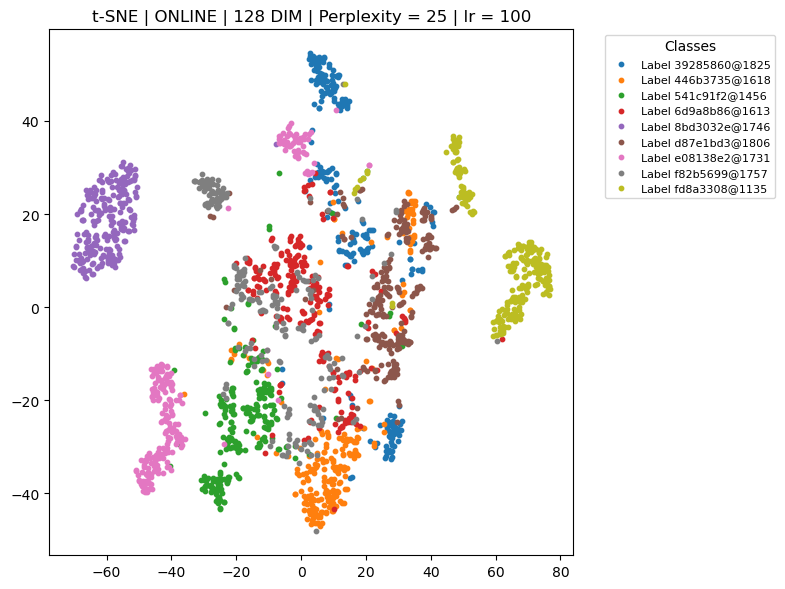

In [52]:
plot_tsne(all_embeddings_online_128, test_labels, perplexity = 25, learning_rate = 100, title = "t-SNE | ONLINE | 128 DIM | Perplexity = 25 | lr = 100")

# Online 256 Embeddings


In [ ]:
model_online_256  = EEGEmbedder(embedding_dim=256).to(device)
optimizer = optim.Adam(model_online_256.parameters(), lr=0.001)
train_triplet_online(model_online_256, train_loader, criterion, optimizer, device, n_epochs = 60)
all_embeddings_online_256, all_labels = extract_embeddings_online(model_online_256, test_loader, device)

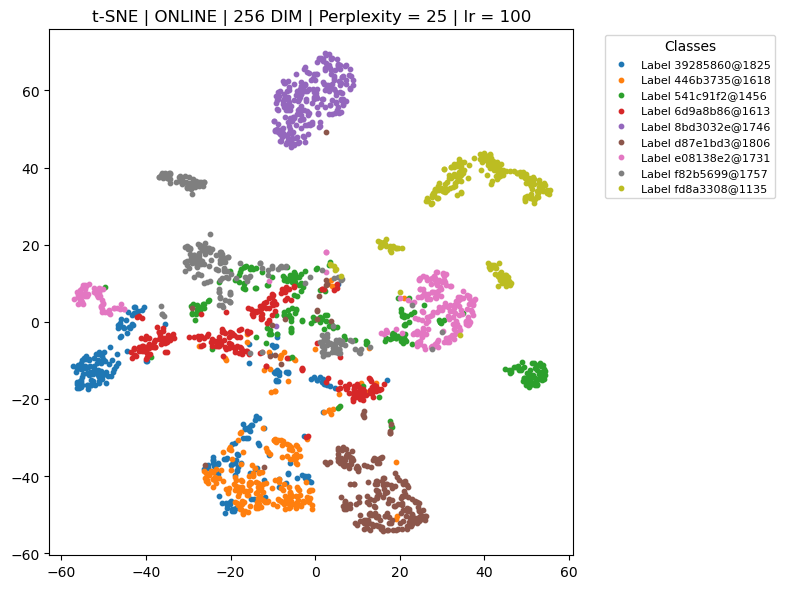

In [54]:
plot_tsne(all_embeddings_online_256, test_labels, perplexity = 25, learning_rate = 100, title = "t-SNE | ONLINE | 256 DIM | Perplexity = 25 | lr = 100")

In [ ]:
# Online 25

In [45]:
model_online  = EEGEmbedder(embedding_dim=256).to(device)
optimizer = optim.Adam(model_online.parameters(), lr=0.001)
train_loader2, test_loader2 = create_online_dataloaders(X_train2, y_train2, X_test2, y_test2)

In [ ]:
train_triplet_online(model_online, train_loader2, criterion, optimizer, device, n_epochs = 60)
all_embeddings_online_256, all_labels = extract_embeddings_online(model_online, test_loader2, device)

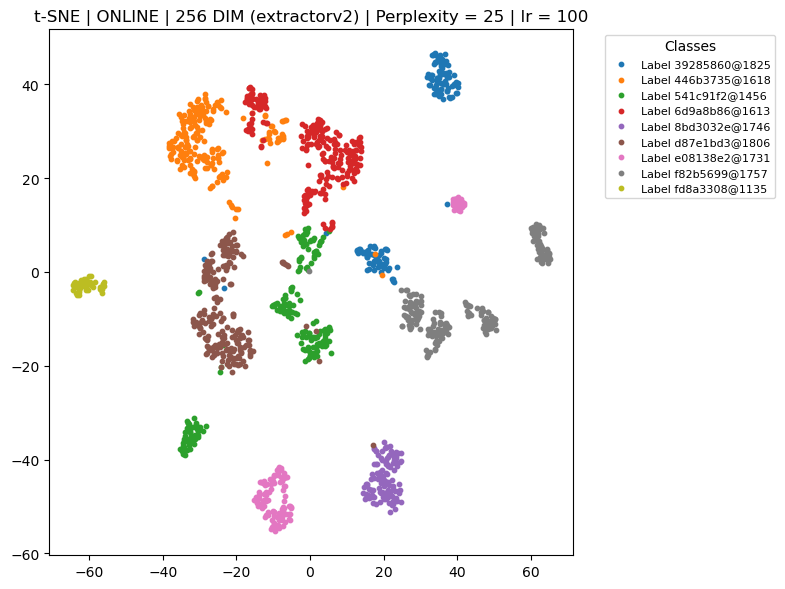

In [50]:
plot_tsne(all_embeddings_online_256, test_labels2, perplexity = 25, learning_rate = 100, title = "t-SNE | ONLINE | 256 DIM (extractorv2) | Perplexity = 25 | lr = 100")